# Convert tabular data to image

Sometimes it's easier to work with convolutional network. Since it provides very good accuracy, sometimes even better than random forest, or XGBoost. 

we are going to use tab2img library

Look [here](https://github.com/nicomignoni/tab2img) for more information

In [1]:
# !pip install tab2img

Load libraries

In [2]:
from sklearn.datasets import fetch_covtype
from tab2img.converter import Tab2Img
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data processing

We are going to use titanic dataset, for no particular reason



In [3]:
train_data = pd.read_csv("data/titanic/train.csv")
test_data  = pd.read_csv("data/titanic/test.csv")

#replace NaN with 0
train_data.fillna(0,inplace=True)
test_data.fillna(0,inplace=True)

# drop useless columns
train_data = train_data.drop(columns=['Name','Cabin','Embarked', 'Ticket'])
train_data['TFamily'] = train_data['SibSp'] + train_data['Parch']
train_data = train_data.drop(columns=['SibSp', 'Parch'])

test_data = test_data.drop(columns=['Name','Cabin','Embarked', 'Ticket'])
test_data['TFamily'] = test_data['SibSp'] + test_data['Parch']
test_data = test_data.drop(columns=['SibSp', 'Parch'])

In [4]:
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived'].values

We need to convert 'sex' column into 1 and 0, where 1 --- stands for male, and 0 --- stands for female

In [5]:
arr = []
for sex in X['Sex']:
    if sex == 'male':
        arr.append(1)
    else:
        arr.append(0)
X['Sex'] = arr

In [6]:
# load data split function
from sklearn.model_selection import train_test_split

In [7]:
#make the x for train and valid
xtrain,xvalid,ytrain,yvalid = train_test_split(X,Y,train_size=0.80,random_state=2)

### Convert to image

In [8]:
model = Tab2Img()
images_train = model.fit_transform(xtrain.to_numpy(), ytrain)
images_valid = model.transform(xvalid.to_numpy())

Now we have images to work with. We can use CNN or any other model to work with thi data. 

In [9]:
images_train

array([[[ 27.7208,   0.    ,   1.    ],
        [ 40.    ,  31.    ,   0.    ],
        [  1.    ,   0.    ,   0.    ]],

       [[ 16.7   ,   2.    ,   3.    ],
        [  4.    ,  11.    ,   0.    ],
        [  0.    ,   0.    ,   0.    ]],

       [[  9.    ,   0.    ,   3.    ],
        [ 47.    , 874.    ,   0.    ],
        [  1.    ,   0.    ,   0.    ]],

       ...,

       [[ 49.5042,   0.    ,   1.    ],
        [ 71.    , 494.    ,   0.    ],
        [  1.    ,   0.    ,   0.    ]],

       [[221.7792,   0.    ,   1.    ],
        [  0.    , 528.    ,   0.    ],
        [  1.    ,   0.    ,   0.    ]],

       [[ 25.925 ,   0.    ,   1.    ],
        [  0.    , 169.    ,   0.    ],
        [  1.    ,   0.    ,   0.    ]]], dtype=float32)

### keras with tensorflow

### fastai

### CNN

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
#блокируем всплавание о предупреждениях
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Igor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [11]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
images_train.shape

(712, 3, 3)

In [13]:
model = Sequential([
    #входной слой
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    #этот слой урезает картинку вдвое. 
    MaxPool2D(pool_size=(2,2), strides=2),    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    #переводим все измерения матрицы в одну плоскость. 
    Flatten(),
    #выходной слой. Т.к. у нас только 2 класса, мы используем units=2
    Dense(units=2, activation='softmax')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# images_train = tf.convert_to_tensor(images_train)
# images_valid = tf.convert_to_tensor(images_valid)

In [17]:
# This function will plot images in the form of a grid with 1 row and 10 column where imags are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

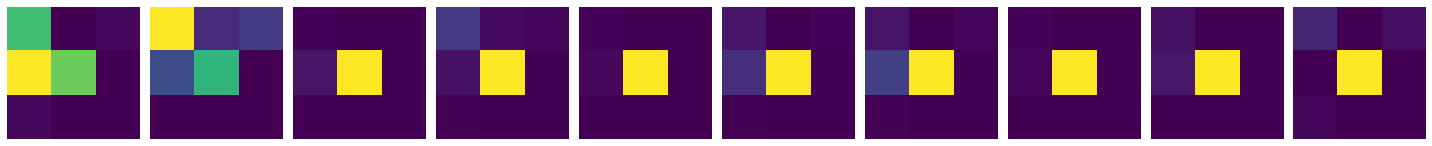

[0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0
 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 1 1 0 0 

In [18]:
plotImages(images_train)
print(ytrain)

надо бы посмотреть, почему tab2img вообще нуждается в таргете. для чего он его использует? 

прогнать пример, который там приводится. 

возможно исопльзовать что-то другое.

* можно попробовать вывести рисунок

* наверное надо сделать flatten. 

In [20]:
model.fit(x=images_train, y=ytrain, validation_split=0.2, epochs=10, verbose=2)

ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (712, 3, 3)

### Bonus section

As a bonus, let's use XGBoost and compare our results

### XGBoost